# Inputs & ToDos

## TodDo


In [1]:
import sys
sys.path.append('..')
from src.data.datamodules.binary_change import BinaryChangeDetectionDataModule
from src.trainers.change import  BinaryChangeSemanticSegmentationTaskBinaryLoss
from src.trainers.utils import find_optimal_learning_rate, setup_training, compute_metrics_from_checkpoint
from pathlib import Path
import torch 
import torchgeo
import lightning as pl
import kornia
import matplotlib.pyplot as plt
import seaborn as sns
torchgeo.__version__, pl.__version__, torch.__version__, kornia.__version__

('0.7.0', '2.5.1', '2.6.0', '0.8.0')

### Define paramters

In [2]:
# Define the input paths
image1_path='/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/flug_2003_rgb.tif'
image2_path='/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/flug_2013_rgb.tif'
mask_path='/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/habitalp_change_2003_2013_B_C_prio3_rasterized_cog.tif'
label_poly_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/habitalp_change_2003_2013_B_C_prio3_transitions_aggregated.gpkg'

train_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_train.gpkg' # If Train ROI changes -> re-compute the class frequencies and weights!! 
val_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_val.gpkg'
test_roi_path = '/home/hkristen/habitalp2/data/processed/orthos_rgb_2003_2013/split_test.gpkg'

experiment_dir = '/home/hkristen/habitalp2/src/models/experiments'


In [8]:
#resnet 50 params - 512x512
# 20 minutes per epoch
patch_size = (256,256) 
batch_size = 48
num_workers = 4
learning_rate = 1e-4
backbone = 'resnet34'
min_epochs = 30
max_epochs = 100
samples_per_epoch = 25000
patience = 20
num_classes = 2

In [4]:
experiment_name = 'binary-change-2003-2013-05-resnet50d_256x256_OneCycleLR'

logging = 'remote'
wandb_project = 'binary-change'
wandb_key = 'YOUR_WANDB_API_KEY_HERE'

## Training prep

### Define Datamodule

In [5]:
torch.manual_seed(2)

datamodule = BinaryChangeDetectionDataModule(
    image1_path,
    image2_path,
    mask_path,
    train_roi_path = train_roi_path,
    val_roi_path = val_roi_path,
    test_roi_path = test_roi_path,
    label_poly_path = label_poly_path,
    patch_size=patch_size,
    batch_size=batch_size,
    num_workers=num_workers,
    samples_per_epoch=samples_per_epoch
)

datamodule.setup()

/home/hkristen/habitalp2/notebooks/../src/data/datamodules/binary_change.py:90: RasterioDeprecationWarning: statistics() will be removed in 2.0.0. Please switch to stats().
  stats = src.statistics(band, approx=False)


Setting up datasets...
Loaded 4480 valid label polygons.
Datasets created successfully


In [9]:
#datamodule.visualize_samples()

### Define the trainer

In [6]:
from src.trainers.utils import compute_class_weights_multiclass, calculate_class_frequencies

# Calculate frequencies & weights 
#class_pixel_counts = calculate_class_frequencies(datamodule, datamodule.num_classes)
#class_weights = compute_class_weights_multiclass(class_pixel_counts)

class_weights = torch.tensor([0.55016005, 1.44984])


In [10]:
gpu_id = 0
torch.set_float32_matmul_precision('high') #make use of tensor cores 


# Initialize your task
task_binaryloss = BinaryChangeSemanticSegmentationTaskBinaryLoss(
    model="fcisam",
    backbone=backbone,
    weights=True,
    in_channels=6,
    num_classes=2,
    loss="bce",
    pos_weight=torch.tensor([class_weights[1]/class_weights[0]]),
    lr=learning_rate,
    patience=patience
)

# Set up training
trainer = setup_training(
    experiment_name=experiment_name,
    experiment_dir=experiment_dir,
    min_epochs=min_epochs,
    max_epochs=max_epochs,
    gpu_id=gpu_id,
    patience=patience,
    wandb_project=wandb_project,
    logging=logging,
    wandb_key=wandb_key 
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hkristen/.netrc
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Find ideal learning rate

In [9]:
# Find optimal learning rate
#suggested_lr, _ = find_optimal_learning_rate(task_binaryloss, datamodule, min_epochs, gpu_id)

## Train models 

In [11]:
_ = trainer.fit(model=task_binaryloss, datamodule=datamodule)

Setting up datasets...


/home/hkristen/miniforge3/envs/geoai2/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hkristen/habitalp2/src/models/experiments exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded 4480 valid label polygons.
Datasets created successfully


ValueError: optimizer got an empty parameter list

### Custom test step to compute the precision, recall, and F1 metrics


In [13]:
from tqdm.auto import tqdm
import numpy as np

checkpoint_path = Path('/home/hkristen/habitalp2/src/models/experiments/binary-change-2003-2013-06-resnet50_binary_loss_512x512_small_roi_RandomInterSectionSampler-epoch=02-step=3126-val_jaccard=0.3917.ckpt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the model from checkpoint
task = BinaryChangeSemanticSegmentationTaskBinaryLoss.load_from_checkpoint(checkpoint_path)
model = task.model.to(device).eval()

y_preds = []
y_trues = []
for batch in tqdm(datamodule.test_dataloader()):
    images = batch["image"].to(device)
    y_trues.append(batch["mask"].numpy().ravel()[::500])
    with torch.inference_mode():
        y_pred = model(images).argmax(dim=1).cpu().numpy().ravel()[::500]
    y_preds.append(y_pred)

y_preds = np.concatenate(y_preds)
y_trues = np.concatenate(y_trues)


Creating test dataloader


  0%|          | 0/209 [00:00<?, ?it/s]

In [27]:
last_ckpt_pth = trainer.checkpoint_callback.last_model_path
best_cpkt_pth = trainer.checkpoint_callback.best_model_path

Creating test dataloader


100%|██████████| 209/209 [00:53<00:00,  3.90it/s]


--- Weighted Average Metrics ---
Precision (Weighted): 0.5092
Recall (Weighted):    0.6823
F1 Score (Weighted):  0.5534


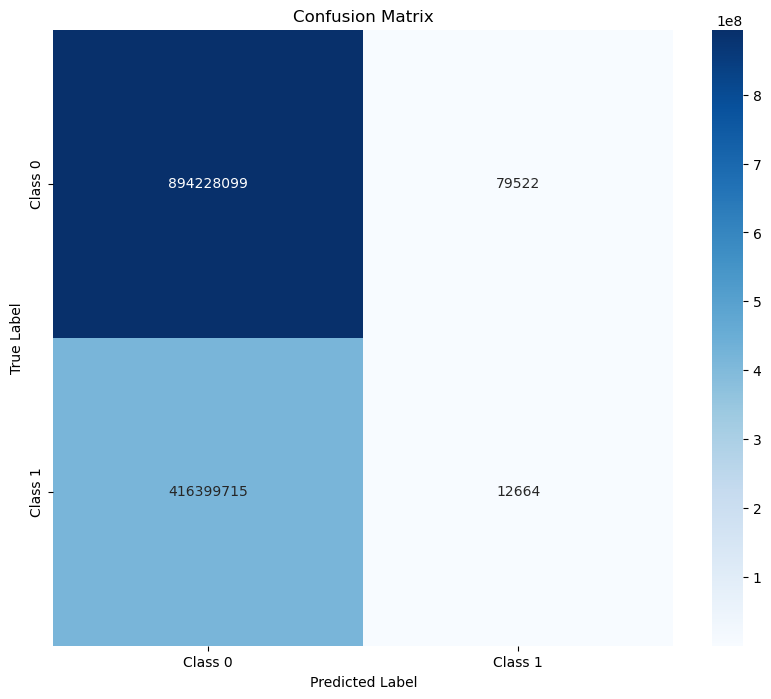


--- Per-Class Metrics ---
Class           Precision  Recall     F1-Score   Support   
-------------------------------------------------------
Class 0         0.6823     0.9999     0.8111     894307621 
Class 1         0.1374     0.0000     0.0001     416412379 
-------------------------------------------------------

Overall Accuracy: 0.6823


In [29]:
#checkpoint_path = '/home/hkristen/habitalp2/src/models/experiments/last-v7.ckpt'
results = compute_metrics_from_checkpoint(last_ckpt_pth, datamodule, BinaryChangeSemanticSegmentationTaskBinaryLoss, None)

# Print results
print("\n--- Weighted Average Metrics ---")
print(f"Precision (Weighted): {results['weighted_metrics']['precision']:.4f}")
print(f"Recall (Weighted):    {results['weighted_metrics']['recall']:.4f}")
print(f"F1 Score (Weighted):  {results['weighted_metrics']['f1']:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=results['class_names'], yticklabels=results['class_names'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print per-class metrics
print("\n--- Per-Class Metrics ---")
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 55)
for class_name, metrics in results['per_class_metrics'].items():
    print(f"{class_name:<15} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} "
          f"{metrics['f1']:<10.4f} {metrics['support']:<10}")
print("-" * 55)
print(f"\nOverall Accuracy: {results['accuracy']:.4f}")

In [30]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_trues, y_preds)
recall = recall_score(y_trues, y_preds)
f1 = 2 * (precision * recall) / (precision + recall)

precision, recall, f1

/home/hkristen/miniforge3/envs/geoai2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ZeroDivisionError: float division by zero